In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy

import numpy as np
import pandas as pd

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import pystarboard.data_spacescope as data_spacescope
import pystarboard.data as filecoin_data
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.date_utils as date_utils
import mechafil.data as d
import mechafil.data_spacescope as dss
import scenario_generator.utils as u
import cel_utils.disk_utils as du

In [3]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
lock_target = 0.3
forecast_length = 365*3
sector_duration = 540

current_date = date(2023, 12, 1)
mo = current_date.month - 6  # start n-months back.  n is governed by how far back we want to look for
                             # examining outflow impact due to burn vs. locked
                             # having this too large should only negative affect forecasts, which we don't use
                             # for this NB, so any number should be OK
if mo == 0: mo = 1
start_date = date(current_date.year, mo, 1)
end_date = current_date + timedelta(days=forecast_length)

print(start_date, current_date, end_date)

2023-06-01 2023-12-01 2026-11-30


In [4]:
# In this case, gas_burn is from sources other than base_fee burn
# get the historical data and use it to make a forecast on gas_burn, by extending median values of historical data
# NOTE: the forecasting complexity could be increased.

sso = data_spacescope.SpacescopeDataConnection(token)
lookback_days = 180
sd = current_date - timedelta(days=lookback_days)
network_fee_breakdown_df = sso.spacescope_query(sd, current_date, 
                     'https://api.spacescope.io/v2/gas/daily_network_fee_breakdown?end_date=%s&start_date=%s')

In [5]:
# get filecoin supply statistics by running mechafil
#  this is needed bc we want to get the outflows for locking due to onboarded power
#  not reward vesting, etc

def get_offline_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    
    return {
        'offline_data': offline_data,
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr
    }

od = get_offline_data()
locals().update(od)

# this is a no-op, since we won't use forecast data but only historical
smooth_historical_rbp = np.median(hist_rbp[-30:])
smooth_historical_rr = np.median(hist_rr[-30:])
smooth_historical_fpr = np.median(hist_fpr[-30:])

rbp = jnp.ones(forecast_length) * smooth_historical_rbp
rr = jnp.ones(forecast_length) * smooth_historical_rr
fpr = jnp.ones(forecast_length) * smooth_historical_fpr

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

In [6]:
# get a baseline burn forecast
other_burns = ['overestimation_burn', 'precommit_batch_fee_burn', 'provecommit_batch_fee_burn', 'penalty_fee_burn', 'miner_tip']
all_burn_cols = ['overestimation_burn', 'precommit_batch_fee_burn', 'provecommit_batch_fee_burn', 'penalty_fee_burn', 'miner_tip', 'base_fee_burn']
burn_without_basefee = network_fee_breakdown_df[other_burns].sum(axis=1).values
burn_basefee_only = network_fee_breakdown_df[['base_fee_burn']].sum(axis=1).values
full_burn = network_fee_breakdown_df[all_burn_cols].sum(axis=1).values
median_burn_pct_notbasefee = np.median(burn_without_basefee/full_burn)
print(median_burn_pct_notbasefee)
print(len(full_burn))

0.46046959006899085
181


In [7]:
simulation_results.keys()

dict_keys(['1y_return_per_sector', '1y_sector_roi', 'capped_power_EIB', 'circ_supply', 'cum_baseline_reward', 'cum_capped_power_EIB', 'cum_network_reward', 'cum_simple_reward', 'day_locked_pledge', 'day_network_reward', 'day_onboarded_power_QAP_PIB', 'day_pledge_per_QAP', 'day_renewed_pledge', 'day_renewed_power_QAP_PIB', 'day_rewards_per_sector', 'days', 'disbursed_reserve', 'full_renewal_rate', 'network_QAP_EIB', 'network_RBP_EIB', 'network_baseline_EIB', 'network_gas_burn', 'network_locked', 'network_locked_pledge', 'network_locked_reward', 'network_time', 'one_year_vest_saft', 'qa_day_onboarded_power_pib', 'qa_day_renewed_power_pib', 'qa_total_power_eib', 'rb_day_onboarded_power_pib', 'rb_day_renewed_power_pib', 'rb_total_power_eib', 'six_month_vest_saft', 'six_year_vest_foundation', 'six_year_vest_pl', 'six_year_vest_saft', 'three_year_vest_saft', 'total_day_vest', 'total_vest', 'two_year_vest_saft'])

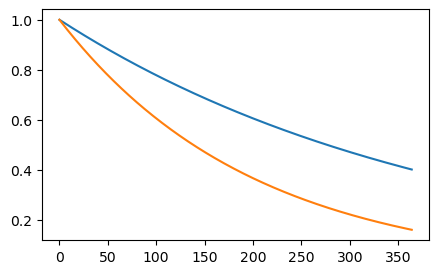

In [26]:
x = np.arange(365)
plt.figure(figsize=(5,3))
plt.plot(x, 1.0/np.exp(0.0025*x))
plt.plot(x, 1.0/np.exp(0.005*x))

In [27]:
day_locked = simulation_results['day_locked_pledge'] + simulation_results['day_renewed_pledge']
day_locked_historical = np.asarray(day_locked[1:len(full_burn)])
day_burn_historical = np.diff(np.asarray(simulation_results['network_gas_burn'])[0:len(full_burn)])
cs_historical = np.asarray(simulation_results['circ_supply'][1:len(full_burn)])
day_outflow = day_locked_historical + day_burn_historical

discount_rate = 0.0025
day_outflow_discounted = (day_locked_historical/np.exp(discount_rate*np.arange(len(day_locked_historical)))) + day_burn_historical

t = date_utils.get_t(start_date+timedelta(days=1), forecast_length=len(full_burn)-1)

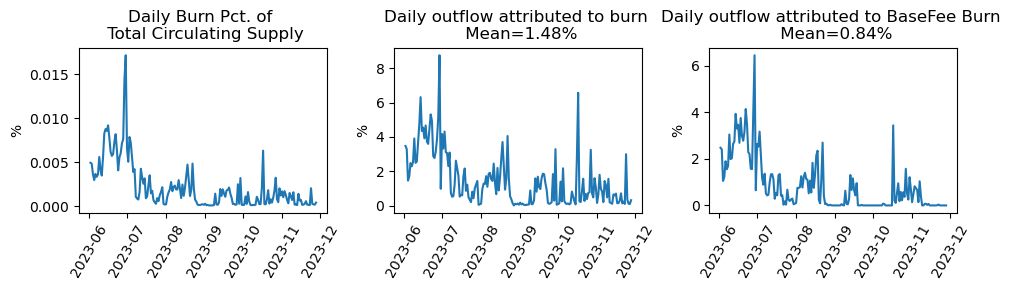

In [34]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.plot(t, day_burn_historical / cs_historical * 100)
plt.ylabel('%')
plt.title('Daily Burn Pct. of \n Total Circulating Supply')
plt.xticks(rotation=60)

plt.subplot(1,3,2)
x1 = day_burn_historical/day_outflow * 100
# x2 = day_burn_historical/day_outflow_discounted * 100
plt.plot(t, x1)
# plt.plot(t, x2, label='Discounted @ %0.01f %%' % (discount_rate*100,), linestyle="--")
# plt.axhline(np.median(x1), linestyle=':', linewidth=1, color='k')
# plt.axhline(np.median(x2), linestyle=':', linewidth=1, color='r', label='Discounted @ %0.01f' % (discount_rate*100,))
plt.ylabel('%')
# plt.legend()
# plt.yscale('log')
# plt.title('Daily outflow attributed to burn \n Mean=%0.02f%% \n Mean(Discounted)=%0.02f%%' % (np.mean(x1),np.mean(x2)))
plt.title('Daily outflow attributed to burn \n Mean=%0.02f%%' % (np.mean(x1),))
plt.xticks(rotation=60)

plt.subplot(133)
x1 = day_burn_historical*(burn_basefee_only[1:]/full_burn[1:])/day_outflow * 100
# x2 = day_burn_historical*(burn_basefee_only[1:]/full_burn[1:])/day_outflow_discounted * 100
plt.plot(t, x1)
# plt.plot(t, x2, label='Discounted @ %0.01f %%' % (discount_rate*100,), linestyle="--")
# plt.axhline(np.median(x1), linestyle=':', linewidth=1, color='k')
# plt.axhline(np.median(x2), linestyle=':', linewidth=1, color='r', label='Discounted @ %0.01f' % (discount_rate*100,))
plt.ylabel('%')
# plt.legend()
# plt.title('Daily outflow attributed to BaseFee Burn \n Mean=%0.02f%% \n Mean(Discounted)=%0.02f%%' % (np.mean(x1),np.mean(x2)))
plt.title('Daily outflow attributed to BaseFee Burn \n Mean=%0.02f%%' % (np.mean(x1),))
plt.xticks(rotation=60)

plt.tight_layout()

save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp_v2')
os.makedirs(save_dir, exist_ok=True)

plt.savefig(os.path.join(save_dir, 'attrib_basefee_burn.png'))

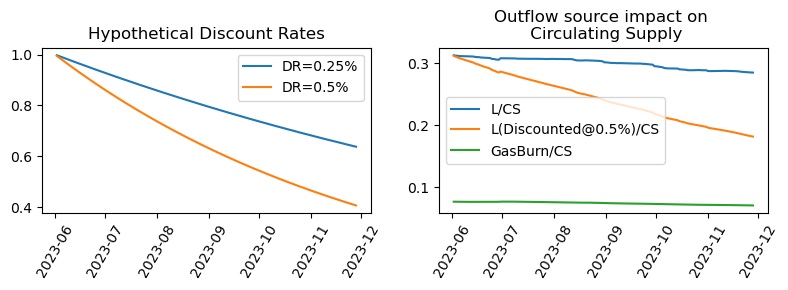

In [57]:
# new graph w/ discount factor
# impact on circulating supply.  burn/cs
#                                discounted locked / cs
# should be cumulative
tt = np.arange(1,len(full_burn))
t = date_utils.get_t(start_date+timedelta(days=1), forecast_length=len(full_burn)-1)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
d1 = 1.0/np.exp(0.0025*tt)
d2 = 1.0/np.exp(0.005*tt)
plt.plot(t, d1, label='DR=0.25%')
plt.plot(t, d2, label='DR=0.5%')
plt.xticks(rotation=60)
plt.legend()
plt.title('Hypothetical Discount Rates')

plt.subplot(1,2,2)
# plt.plot(cs_historical)
plt.plot(t, simulation_results['network_locked'][1:len(full_burn)]/cs_historical, label='L/CS')
plt.plot(t, simulation_results['network_locked'][1:len(full_burn)]*discount/cs_historical, label='L(Discounted@0.5%)/CS')
plt.plot(t, simulation_results['network_gas_burn'][1:len(full_burn)]/cs_historical, label='GasBurn/CS')
plt.title('Outflow source impact on \n Circulating Supply')
plt.xticks(rotation=60)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'impact_discount_rate.png'))

In [43]:
len(full_burn)

181